## Import Library & Load Dataset

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop_words = set(stopwords.words('english'))

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
data = pd.read_csv("Restaurant_Reviews.tsv", delimiter="\t", quoting=3)
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [36]:
print(data['Review'].iloc[0],"\n")
print(data['Review'].iloc[1],"\n")
print(data['Review'].iloc[2],"\n")
print(data['Review'].iloc[3],"\n")
print(data['Review'].iloc[4],"\n")

Wow... Loved this place. 

Crust is not good. 

Not tasty and the texture was just nasty. 

Stopped by during the late May bank holiday off Rick Steve recommendation and loved it. 

The selection on the menu was great and so were the prices. 



review positif 1 dan negatif 0

## Data cleaning

In [37]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_token = word_tokenize(text)
    filter_text = [w for w in text_token if not w in stop_words]
    return " ".join(filter_text)

In [38]:
data["Review"] = data["Review"].apply(clean_text)

#### Stemming

In [39]:
stemmer = PorterStemmer()
def steaming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [40]:
data["Review"] = data["Review"].apply(lambda x: steaming(x))

In [41]:
data.Liked.value_counts()

1    500
0    500
Name: Liked, dtype: int64

## Model Building TF-IDF

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [43]:
X = data.Review
y = data.Liked

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800,), (200,), (800,), (200,))

In [46]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', LogisticRegression(solver='lbfgs',n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 3.0615887173812686, 'algo__fit_intercept': True}
0.98375 0.7899899561638177 0.785


### Metric for Classification

Test Akurasi : 0.785
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        96
           1       0.84      0.73      0.78       104

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.78       200
weighted avg       0.79      0.79      0.78       200



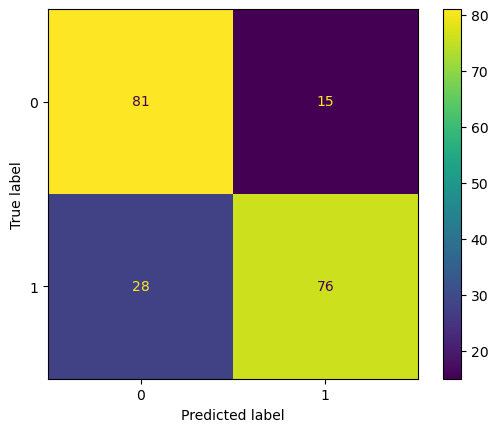

In [47]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print(f'Test Akurasi : {acc}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot();

In [51]:
new_tweet = ['This amazing, I like thi restaurant']
model.predict(new_tweet)

array([1], dtype=int64)

In [52]:
sample_review = ['Food was pretty bad and the service was very slow.']
model.predict(sample_review)

array([0], dtype=int64)